# Imports

In [1]:
import io
import gc
import os
import cv2
import torch
import requests
import tempfile
import contextlib
import numpy as np
import open3d as o3d
from PIL import Image
from numba import cuda
from typing import List
import matplotlib.pyplot as plt
from transformers import pipeline
from torchvision import transforms
from detector_utils import adapt_mmdet_pipeline, init_detector, process_images_detector
from classes_and_palettes import (
    COCO_KPTS_COLORS,
    COCO_WHOLEBODY_KPTS_COLORS,
    GOLIATH_KPTS_COLORS,
    GOLIATH_SKELETON_INFO,
    GOLIATH_KEYPOINTS,
    GOLIATH_PALETTE, 
    GOLIATH_CLASSES
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/ilyass/workspace/sapiens/engine/mmengine/optim/optimizer/zero_optimizer.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


# Classes

In [2]:
class Config:
    ASSETS_DIR = "../assets/"
    CHECKPOINTS_DIR = "../assets/checkpoints/"
    CHECKPOINTS = {
        "0.3bp": "pose/sapiens_0.3b_goliath_best_goliath_AP_575_torchscript.pt2",
        "1bp": "pose/sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2",

        "0.3s": "segmentation/sapiens_0.3b_goliath_best_goliath_mIoU_7673_epoch_194_torchscript.pt2",
        "0.6s": "segmentation/sapiens_0.6b_goliath_best_goliath_mIoU_7777_epoch_178_torchscript.pt2",
        "1bs": "segmentation/sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2"
    }
    DETECTION_CHECKPOINT = "../assets/checkpoints/pose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth"
    DETECTION_CONFIG = "../assets/assets_rtmdet_m_640-8xb32_coco-person_no_nms.py"

In [3]:
class ModelManager:
    @staticmethod
    def load_model(checkpoint_name: str):
        if checkpoint_name is None:
            return None

        checkpoint_path = os.path.join(Config.CHECKPOINTS_DIR, checkpoint_name)
        model = torch.jit.load(checkpoint_path)
        model.eval()
        model.to(device)
        
        return model

    @staticmethod
    @torch.inference_mode()
    def run_model_keypoints(model, input_tensor):
        return model(input_tensor)

    @staticmethod
    @torch.inference_mode()
    def run_model_segmentation(model, input_tensor, height, width):
        output = model(input_tensor)
        output = torch.nn.functional.interpolate(output, size=(height, width), mode="bilinear", align_corners=False)
        _, preds = torch.max(output, 1)
        return preds

In [4]:
class ImageProcessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((1024, 768)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[123.5/255, 116.5/255, 103.5/255], 
                                 std=[58.5/255, 57.0/255, 57.5/255])
        ])
        self.detector = init_detector(
            Config.DETECTION_CONFIG, Config.DETECTION_CHECKPOINT, device='cpu'
        )
        self.detector.cfg = adapt_mmdet_pipeline(self.detector.cfg)

    def detect_persons(self, image: Image.Image):
        # Convert PIL Image to tensor
        image = np.array(image)
        image = np.expand_dims(image, axis=0)

        # Perform person detection
        bboxes_batch = process_images_detector(
            image, 
            self.detector
        )
        bboxes = self.get_person_bboxes(bboxes_batch[0])  # Get bboxes for the first (and only) image
        
        return bboxes
    
    def get_person_bboxes(self, bboxes_batch, score_thr=0.3):
        person_bboxes = []
        for bbox in bboxes_batch:
            if len(bbox) == 5:  # [x1, y1, x2, y2, score]
                if bbox[4] > score_thr:
                    person_bboxes.append(bbox)
            elif len(bbox) == 4:  # [x1, y1, x2, y2]
                person_bboxes.append(bbox + [1.0])  # Add a default score of 1.0
        return person_bboxes

    @torch.inference_mode()
    def estimate_pose(self, image: Image.Image, bboxes: List[List[float]], model_name: str, kpt_threshold: float):
        pose_model = ModelManager.load_model(Config.CHECKPOINTS[model_name])
        
        result_image = image.copy()
        all_keypoints = []  # List to store keypoints for all persons

        for bbox in bboxes:
            cropped_img = self.crop_image(result_image, bbox)
            input_tensor = self.transform(cropped_img).unsqueeze(0).to(device)
            heatmaps = ModelManager.run_model_keypoints(pose_model, input_tensor)
            keypoints = self.heatmaps_to_keypoints(heatmaps[0].cpu().numpy())
            all_keypoints.append(keypoints)  # Collect keypoints
            result_image = self.draw_keypoints(result_image, keypoints, bbox, kpt_threshold)
        
        return result_image, all_keypoints

    def process_image_keypoints(self, image: Image.Image, model_name: str, kpt_threshold: str):
        bboxes = self.detect_persons(image)
        result_image, keypoints = self.estimate_pose(image, bboxes, model_name, float(kpt_threshold))
        return result_image, keypoints

    def process_image_segmentation(self, image: Image.Image, model_name: str):
        model = ModelManager.load_model(Config.CHECKPOINTS[model_name])
        input_tensor = self.transform(image).unsqueeze(0).to("cuda")
        
        preds = ModelManager.run_model_segmentation(model, input_tensor, image.height, image.width)
        mask = preds.squeeze(0).cpu().numpy()

        # Visualize the segmentation
        blended_image = self.visualize_pred_with_overlay(image, mask)

        # Create downloadable .npy file
        npy_path = tempfile.mktemp(suffix='.npy')
        np.save(npy_path, mask)

        return blended_image, npy_path

    def crop_image(self, image, bbox):
        if len(bbox) == 4:
            x1, y1, x2, y2 = map(int, bbox)
        elif len(bbox) >= 5:
            x1, y1, x2, y2, _ = map(int, bbox[:5])
        else:
            raise ValueError(f"Unexpected bbox format: {bbox}")
        
        crop = image.crop((x1, y1, x2, y2))
        return crop

    @staticmethod
    def heatmaps_to_keypoints(heatmaps):
        num_joints = heatmaps.shape[0]  # Should be 308
        keypoints = {}
        for i, name in enumerate(GOLIATH_KEYPOINTS):
            if i < num_joints:
                heatmap = heatmaps[i]
                y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
                conf = heatmap[y, x]
                keypoints[name] = (float(x), float(y), float(conf))
        return keypoints

    @staticmethod
    def draw_keypoints(image, keypoints, bbox, kpt_threshold):
        image = np.array(image)

        # Handle both 4 and 5-element bounding boxes
        if len(bbox) == 4:
            x1, y1, x2, y2 = map(int, bbox)
        elif len(bbox) >= 5:
            x1, y1, x2, y2, _ = map(int, bbox[:5])
        else:
            raise ValueError(f"Unexpected bbox format: {bbox}")
                
        # Calculate adaptive radius and thickness based on bounding box size
        bbox_width = x2 - x1
        bbox_height = y2 - y1
        bbox_size = np.sqrt(bbox_width * bbox_height)
        
        radius = max(1, int(bbox_size * 0.006))  # minimum 1 pixel
        thickness = max(1, int(bbox_size * 0.006))  # minimum 1 pixel
        bbox_thickness = max(1, thickness//4)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), bbox_thickness)
        
        # Draw keypoints
        for i, (name, (x, y, conf)) in enumerate(keypoints.items()):
            if conf > kpt_threshold and i < len(GOLIATH_KPTS_COLORS):
                x_coord = int(x * bbox_width / 192) + x1
                y_coord = int(y * bbox_height / 256) + y1
                color = GOLIATH_KPTS_COLORS[i]
                cv2.circle(image, (x_coord, y_coord), radius, color, -1)

        # Draw skeleton
        for _, link_info in GOLIATH_SKELETON_INFO.items():
            pt1_name, pt2_name = link_info['link']
            color = link_info['color']
            
            if pt1_name in keypoints and pt2_name in keypoints:
                pt1 = keypoints[pt1_name]
                pt2 = keypoints[pt2_name]
                if pt1[2] > kpt_threshold and pt2[2] > kpt_threshold:
                    x1_coord = int(pt1[0] * bbox_width / 192) + x1
                    y1_coord = int(pt1[1] * bbox_height / 256) + y1
                    x2_coord = int(pt2[0] * bbox_width / 192) + x1
                    y2_coord = int(pt2[1] * bbox_height / 256) + y1
                    cv2.line(image, (x1_coord, y1_coord), (x2_coord, y2_coord), color, thickness=thickness)

        return Image.fromarray(image)

    @staticmethod
    def visualize_pred_with_overlay(img, sem_seg, alpha=0.5):
        img_np = np.array(img.convert("RGB"))
        sem_seg = np.array(sem_seg)

        num_classes = len(GOLIATH_CLASSES)
        ids = np.unique(sem_seg)[::-1]
        legal_indices = ids < num_classes
        ids = ids[legal_indices]
        labels = np.array(ids, dtype=np.int64)

        colors = [GOLIATH_PALETTE[label] for label in labels]

        overlay = np.zeros((*sem_seg.shape, 3), dtype=np.uint8)

        for label, color in zip(labels, colors):
            overlay[sem_seg == label, :] = color

        blended = np.uint8(img_np * (1 - alpha) + overlay * alpha)
        return Image.fromarray(blended)

# Device Definition

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Depth Estimation

In [6]:
# Load RGB image
rgb_image = Image.open("../input/test1.png").convert('RGB')

### DepthAnythingV2

In [7]:
# Load depth estimation pipeline
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
# Compute relative depth estimation
depth_image = pipe(rgb_image)["depth"]

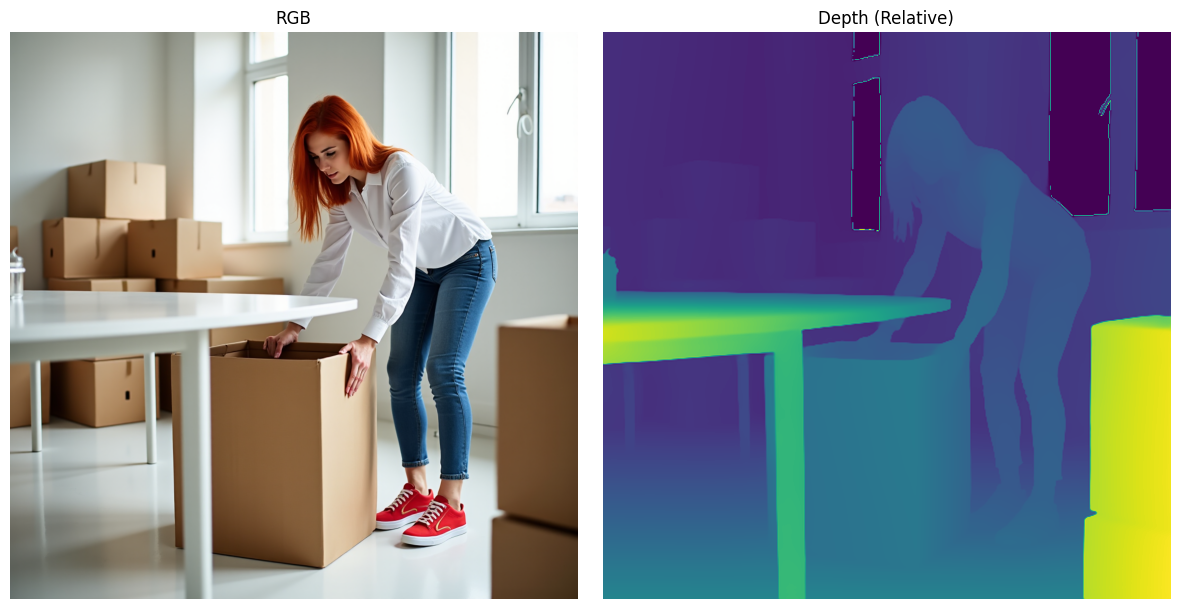

In [9]:
# Plot RGB and depth side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image
ax1.imshow(rgb_image)
ax1.set_title('RGB')
ax1.axis('off')  # Hide axes

# Plot the second image
ax2.imshow(depth_image)
ax2.set_title('Depth (Relative)')
ax2.axis('off')  # Hide axes

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Sapiens Foundation Models

In [10]:
def clean_gpu():
    with torch.no_grad():
        torch.cuda.empty_cache()

In [11]:
image_processor = ImageProcessor()

Loads checkpoint by local backend from path: ../assets/checkpoints/pose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth on server: atari
Done: Loaded checkpoint from ../assets/checkpoints/pose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth on server: atari


/home/ilyass/workspace/sapiens/engine/mmengine/runner/checkpoint.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=map_loc

### Segmentation

In [12]:
segmentation_image, npy_path = image_processor.process_image_segmentation(rgb_image, "1bs")
clean_gpu()

### Keypoints

In [19]:
keypoints_image, keypoints = image_processor.process_image_keypoints(rgb_image, "1bp", 0.3)
with torch.no_grad():
    torch.cuda.empty_cache()

/home/ilyass/workspace/sapiens/det/mmdet/models/layers/se_layer.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/ilyass/workspace/sapiens/det/mmdet/models/backbones/csp_darknet.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


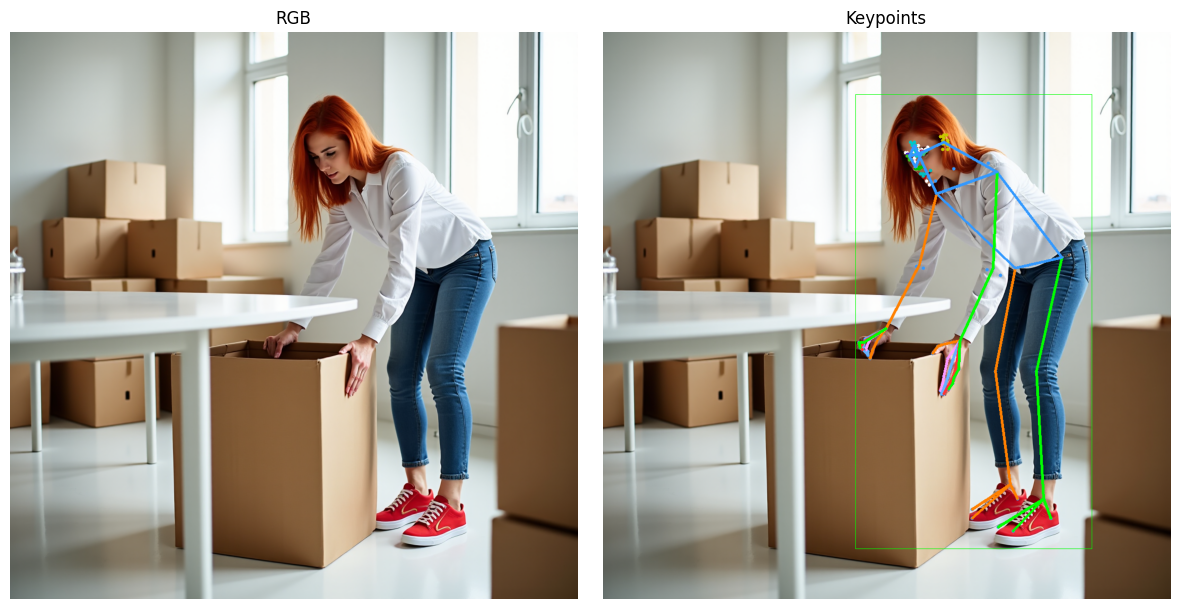

In [20]:
# Plot RGB and depth side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image
ax1.imshow(rgb_image)
ax1.set_title('RGB')
ax1.axis('off')  # Hide axes

# Plot the second image
ax2.imshow(keypoints_image)
ax2.set_title('Keypoints')
ax2.axis('off')  # Hide axes

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()